In [46]:
# ==============================================================================
#
#     Procedural Time Series Model Analysis with Detailed Hyperparameters
#
# This script trains and evaluates five deep learning models.
#
# KEY FEATURES OF THIS VERSION:
# - Each model has a dedicated section with EXPLICITLY COMMENTED hyperparameters
#   to make understanding and tuning easy.
# - The training loop provides a verbose log for each epoch.
# - R-squared (R²), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE)
#   are now calculated for all models.
# - A final section plots all training losses and individual train vs. val losses.
#
# ==============================================================================

# ==============================================================================
# Part 1: Global Setup and Data Preprocessing
# ==============================================================================


In [47]:

# --- Step 1.1: Import Necessary Libraries ---
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # <-- ADDED METRICS
import matplotlib.pyplot as plt
import itertools  # Required for chaining model parameters

print("Libraries imported successfully.")



Libraries imported successfully.


In [48]:

# --- Step 1.2: Load the Dataset ---
print("\nLoading the dataset...")
# !!! IMPORTANT: Update this file path to match the location of your CSV file.
file_path = "C:/Users/impra/Desktop/Practice/A Data ML Algo/A-New.csv"
df = pd.read_csv(file_path)
print(f"Dataset loaded. Initial shape: {df.shape}")




Loading the dataset...
Dataset loaded. Initial shape: (50000, 9)


In [49]:

# --- Step 1.3: Preprocess the Data ---
print("\nPreprocessing 'Date & Time' and handling missing values...")
df["Date & Time"] = pd.to_datetime(df["Date & Time"], errors='coerce')
df.dropna(inplace=True)
print(f"DataFrame shape after cleaning: {df.shape}")




Preprocessing 'Date & Time' and handling missing values...


C:\Users\impra\AppData\Local\Temp\ipykernel_6048\641350113.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date & Time"] = pd.to_datetime(df["Date & Time"], errors='coerce')


DataFrame shape after cleaning: (50000, 9)


In [50]:

# --- Step 1.4: Feature Engineering ---
print("\nExtracting time-based features (hour, dayofweek, month)...")
df["hour"] = df["Date & Time"].dt.hour
df["dayofweek"] = df["Date & Time"].dt.dayofweek
df["month"] = df["Date & Time"].dt.month




Extracting time-based features (hour, dayofweek, month)...


In [51]:

# --- Step 1.5: Separate Features and Target ---
print("\nSeparating features and target variable...")
features = df.drop(columns=["Date & Time", "Total"])
target = df["Total"]




Separating features and target variable...


In [52]:

# --- Step 1.6: Normalize the Data ---
print("\nScaling features and target to the [0, 1] range...")
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))




Scaling features and target to the [0, 1] range...


In [53]:

# --- Step 1.7: Create Time Series Sequences ---
# HYPERPARAMETER: The length of the input sequence for the models.
SEQ_LEN = 48
print(f"\nCreating sequences of length {SEQ_LEN}...")
X, Y = [], []
for i in range(len(features_scaled) - SEQ_LEN):
    X.append(features_scaled[i:i+SEQ_LEN])
    Y.append(target_scaled[i+SEQ_LEN-1])
X = np.array(X)
Y = np.array(Y)
print(f"Shape of X (sequences): {X.shape}, Shape of Y (targets): {Y.shape}")




Creating sequences of length 48...
Shape of X (sequences): (49952, 48, 10), Shape of Y (targets): (49952, 1)


In [54]:

# --- Step 1.8: Split Data into Training, Validation, and Test Sets ---
print("\nSplitting the data into train (70%), validation (15%), and test (15%) sets...")
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]
print(f"Train shapes: {X_train.shape}, {Y_train.shape}")
print(f"Validation shapes: {X_val.shape}, {Y_val.shape}")
print(f"Test shapes: {X_test.shape}, {Y_test.shape}")




Splitting the data into train (70%), validation (15%), and test (15%) sets...
Train shapes: (34966, 48, 10), (34966, 1)
Validation shapes: (7492, 48, 10), (7492, 1)
Test shapes: (7494, 48, 10), (7494, 1)


In [55]:

# --- Step 1.9: Convert Data to PyTorch Tensors ---
print("\nConverting NumPy arrays to PyTorch tensors...")
X_train=torch.tensor(X_train, dtype=torch.float32)
Y_train=torch.tensor(Y_train, dtype=torch.float32)
X_val=torch.tensor(X_val, dtype=torch.float32)
Y_val=torch.tensor(Y_val, dtype=torch.float32)
X_test=torch.tensor(X_test, dtype=torch.float32)
Y_test=torch.tensor(Y_test, dtype=torch.float32)




Converting NumPy arrays to PyTorch tensors...


In [56]:

# --- Step 1.10: Set Up Computation Device and History Dictionaries ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nComputation device set to: {device}")
loss_history = {}
val_loss_history = {}
r2_scores = {}
rmse_scores = {}
mae_scores = {}
print("Initialized dictionaries to store training/validation loss and final metrics.")



Computation device set to: cuda
Initialized dictionaries to store training/validation loss and final metrics.


In [57]:

# ==============================================================================
# Part 2: Procedural Temporal Convolutional Network (TCN)
# ==============================================================================
print("\n\n" + "="*60); print("PART 2: PROCEDURAL TCN"); print("="*60)
# --- TCN Hyperparameters & Setup ---
print("\n--- Setting up TCN Model Parameters ---")
# Model Architecture Parameters
TCN_INPUT_DIM = X_train.shape[2]   # Input features. Determined by data.
TCN_CHANNELS = 64                  # HYPERPARAMETER: Number of filters in conv layers. Controls model capacity.
TCN_KERNEL_SIZE_1 = 7              # HYPERPARAMETER: Kernel size for the first Conv1D layer.
TCN_KERNEL_SIZE_2 = 5              # HYPERPARAMETER: Kernel size for the second Conv1D layer.
TCN_OUTPUT_DIM = 1                 # Output dimension (1 for single value prediction).




PART 2: PROCEDURAL TCN

--- Setting up TCN Model Parameters ---


In [58]:

# Training Hyperparameters
TCN_EPOCHS = 20
TCN_BATCH_SIZE = 32
TCN_LEARNING_RATE = 0.001

tcn_conv_stack = nn.Sequential(
    nn.Conv1d(TCN_INPUT_DIM, TCN_CHANNELS, TCN_KERNEL_SIZE_1, padding=(TCN_KERNEL_SIZE_1 - 1) // 2), nn.ReLU(),
    nn.Conv1d(TCN_CHANNELS, TCN_CHANNELS, TCN_KERNEL_SIZE_2, padding=(TCN_KERNEL_SIZE_2 - 1) // 2), nn.ReLU(),
    nn.AdaptiveAvgPool1d(1)
).to(device)
tcn_fc_layer = nn.Linear(TCN_CHANNELS, TCN_OUTPUT_DIM).to(device)
tcn_optimizer = torch.optim.Adam(itertools.chain(tcn_conv_stack.parameters(), tcn_fc_layer.parameters()), lr=TCN_LEARNING_RATE)
tcn_criterion = nn.MSELoss()
tcn_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=TCN_BATCH_SIZE, shuffle=True)
loss_history['TCN'] = []
val_loss_history['TCN'] = []


In [59]:

# --- TCN Model Training ---
print("\n--- Starting TCN Model Training ---")
for epoch in range(TCN_EPOCHS):
    tcn_conv_stack.train()
    tcn_fc_layer.train()
    running_loss = 0.0
    for xb, yb in tcn_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        features = tcn_conv_stack(xb.permute(0, 2, 1))
        pred = tcn_fc_layer(features.squeeze(-1))
        loss = tcn_criterion(pred, yb)
        tcn_optimizer.zero_grad()
        loss.backward()
        tcn_optimizer.step()
        running_loss += loss.item()
        
    avg_epoch_loss = running_loss / len(tcn_train_loader)
    loss_history['TCN'].append(avg_epoch_loss)
    tcn_conv_stack.eval()
    tcn_fc_layer.eval()
    with torch.no_grad():
        val_features = tcn_conv_stack(X_val.to(device).permute(0, 2, 1))
        val_pred = tcn_fc_layer(val_features.squeeze(-1))
        val_loss = tcn_criterion(val_pred, Y_val.to(device))
        val_loss_history['TCN'].append(val_loss.item())
        
    print(f"TCN Epoch {epoch+1:2d}/{TCN_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")
print("--- TCN Training Complete ---")



--- Starting TCN Model Training ---
TCN Epoch  1/20 | Train Loss: 0.005031 | Val Loss: 0.000435
TCN Epoch  2/20 | Train Loss: 0.000091 | Val Loss: 0.000300
TCN Epoch  3/20 | Train Loss: 0.000020 | Val Loss: 0.000330
TCN Epoch  4/20 | Train Loss: 0.000011 | Val Loss: 0.000299
TCN Epoch  5/20 | Train Loss: 0.000008 | Val Loss: 0.000382
TCN Epoch  6/20 | Train Loss: 0.000005 | Val Loss: 0.000371
TCN Epoch  7/20 | Train Loss: 0.000005 | Val Loss: 0.000500
TCN Epoch  8/20 | Train Loss: 0.000004 | Val Loss: 0.000735
TCN Epoch  9/20 | Train Loss: 0.000003 | Val Loss: 0.000501
TCN Epoch 10/20 | Train Loss: 0.000003 | Val Loss: 0.000521
TCN Epoch 11/20 | Train Loss: 0.000002 | Val Loss: 0.000455
TCN Epoch 12/20 | Train Loss: 0.000002 | Val Loss: 0.000479
TCN Epoch 13/20 | Train Loss: 0.000002 | Val Loss: 0.000464
TCN Epoch 14/20 | Train Loss: 0.000004 | Val Loss: 0.000382
TCN Epoch 15/20 | Train Loss: 0.000001 | Val Loss: 0.000405
TCN Epoch 16/20 | Train Loss: 0.000003 | Val Loss: 0.000410
TCN

In [60]:

# --- TCN Model Evaluation ---
tcn_conv_stack.eval()
tcn_fc_layer.eval()
with torch.no_grad():
    features = tcn_conv_stack(X_test.to(device).permute(0, 2, 1))
    tcn_preds = tcn_fc_layer(features.squeeze(-1))
    tcn_preds_rescaled = target_scaler.inverse_transform(tcn_preds.cpu().numpy())
tcn_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())



TCN Final R² Score: 0.9097
TCN Final RMSE:       3.0497
TCN Final MAE:        3.0226


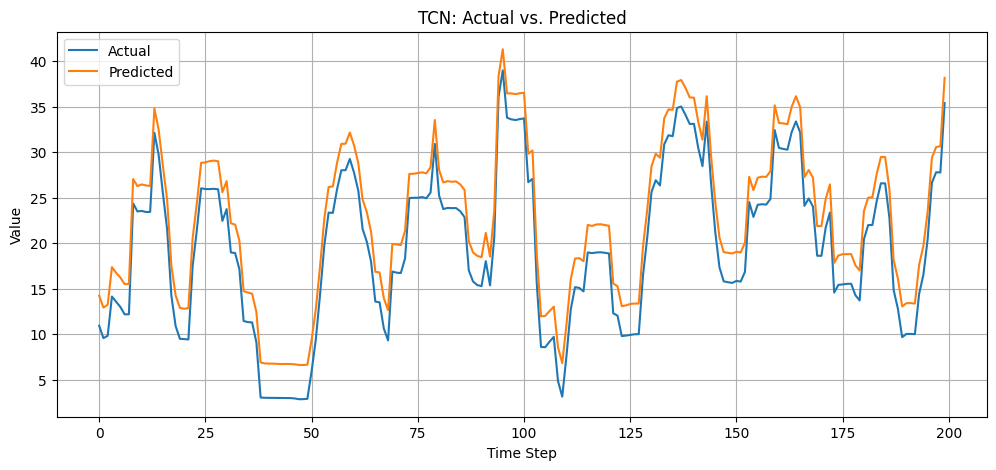

In [61]:

# Calculate and Store Metrics
tcn_r2 = r2_score(tcn_true_rescaled, tcn_preds_rescaled)
tcn_rmse = np.sqrt(mean_squared_error(tcn_true_rescaled, tcn_preds_rescaled))
tcn_mae = mean_absolute_error(tcn_true_rescaled, tcn_preds_rescaled)
r2_scores['TCN'] = tcn_r2
rmse_scores['TCN'] = tcn_rmse
mae_scores['TCN'] = tcn_mae

print(f"\nTCN Final R² Score: {tcn_r2:.4f}")
print(f"TCN Final RMSE:       {tcn_rmse:.4f}")
print(f"TCN Final MAE:        {tcn_mae:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(tcn_true_rescaled[:200], label='Actual')
plt.plot(tcn_preds_rescaled[:200], label='Predicted')
plt.title('TCN: Actual vs. Predicted')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [62]:

# ==============================================================================
# Part 3: Procedural Unidirectional LSTM
# ==============================================================================
print("\n\n" + "="*60); print("PART 3: PROCEDURAL UNIDIRECTIONAL LSTM"); print("="*60)
# --- LSTM Hyperparameters & Model Configuration ---
print("\n--- Setting up LSTM Model Parameters ---")
# Model Architecture Parameters
LSTM_INPUT_DIM = X_train.shape[2]      # Input features. Determined by data.
LSTM_HIDDEN_DIM = 64                   # HYPERPARAMETER: Size of LSTM's hidden state. Controls model memory/capacity.
LSTM_NUM_LAYERS = 1                    # HYPERPARAMETER: Number of stacked LSTM layers. >1 for a "deep" LSTM.
LSTM_OUTPUT_DIM = 1                    # Output dimension.
LSTM_DROPOUT = 0.0                     # HYPERPARAMETER: Dropout rate for regularization (if NUM_LAYERS > 1).






PART 3: PROCEDURAL UNIDIRECTIONAL LSTM

--- Setting up LSTM Model Parameters ---


In [63]:

# Training Hyperparameters
LSTM_EPOCHS = 20
LSTM_BATCH_SIZE = 32
LSTM_LEARNING_RATE = 0.001

lstm_layer = nn.LSTM(LSTM_INPUT_DIM, LSTM_HIDDEN_DIM, LSTM_NUM_LAYERS, batch_first=True, dropout=LSTM_DROPOUT).to(device)
lstm_fc_layer = nn.Linear(LSTM_HIDDEN_DIM, LSTM_OUTPUT_DIM).to(device)
lstm_optimizer = torch.optim.Adam(itertools.chain(lstm_layer.parameters(), lstm_fc_layer.parameters()), lr=LSTM_LEARNING_RATE)
lstm_criterion = nn.MSELoss()
lstm_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=LSTM_BATCH_SIZE, shuffle=True)
loss_history['LSTM'] = []
val_loss_history['LSTM'] = []


In [64]:

# --- LSTM Model Training ---
print("\n--- Starting LSTM Model Training ---")
for epoch in range(LSTM_EPOCHS):
    lstm_layer.train()
    lstm_fc_layer.train()
    running_loss = 0.0
    for xb, yb in lstm_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        rnn_out, _ = lstm_layer(xb)
        pred = lstm_fc_layer(rnn_out[:, -1, :])
        loss = lstm_criterion(pred, yb)
        lstm_optimizer.zero_grad()
        loss.backward()
        lstm_optimizer.step()
        running_loss += loss.item()
    avg_epoch_loss = running_loss / len(lstm_train_loader)
    loss_history['LSTM'].append(avg_epoch_loss)
    
    lstm_layer.eval()
    lstm_fc_layer.eval()
    with torch.no_grad():
        rnn_out, _ = lstm_layer(X_val.to(device))
        val_pred = lstm_fc_layer(rnn_out[:, -1, :])
        val_loss = lstm_criterion(val_pred, Y_val.to(device))
        val_loss_history['LSTM'].append(val_loss.item())
        
    print(f"LSTM Epoch {epoch+1:2d}/{LSTM_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")
print("--- LSTM Training Complete ---")



--- Starting LSTM Model Training ---
LSTM Epoch  1/20 | Train Loss: 0.001692 | Val Loss: 0.000208
LSTM Epoch  2/20 | Train Loss: 0.000005 | Val Loss: 0.000160
LSTM Epoch  3/20 | Train Loss: 0.000002 | Val Loss: 0.000118
LSTM Epoch  4/20 | Train Loss: 0.000002 | Val Loss: 0.000096
LSTM Epoch  5/20 | Train Loss: 0.000001 | Val Loss: 0.000091
LSTM Epoch  6/20 | Train Loss: 0.000001 | Val Loss: 0.000096
LSTM Epoch  7/20 | Train Loss: 0.000001 | Val Loss: 0.000100
LSTM Epoch  8/20 | Train Loss: 0.000001 | Val Loss: 0.000111
LSTM Epoch  9/20 | Train Loss: 0.000001 | Val Loss: 0.000118
LSTM Epoch 10/20 | Train Loss: 0.000001 | Val Loss: 0.000115
LSTM Epoch 11/20 | Train Loss: 0.000001 | Val Loss: 0.000141
LSTM Epoch 12/20 | Train Loss: 0.000001 | Val Loss: 0.000173
LSTM Epoch 13/20 | Train Loss: 0.000001 | Val Loss: 0.000178
LSTM Epoch 14/20 | Train Loss: 0.000001 | Val Loss: 0.000190
LSTM Epoch 15/20 | Train Loss: 0.000001 | Val Loss: 0.000213
LSTM Epoch 16/20 | Train Loss: 0.000001 | Val L

In [65]:

# --- LSTM Model Evaluation ---
lstm_layer.eval()
lstm_fc_layer.eval()
with torch.no_grad():
    rnn_out, _ = lstm_layer(X_test.to(device))
    lstm_preds = lstm_fc_layer(rnn_out[:, -1, :])
    lstm_preds_rescaled = target_scaler.inverse_transform(lstm_preds.cpu().numpy())
lstm_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())



LSTM Final R² Score: 0.9411
LSTM Final RMSE:       2.4634
LSTM Final MAE:        2.4593


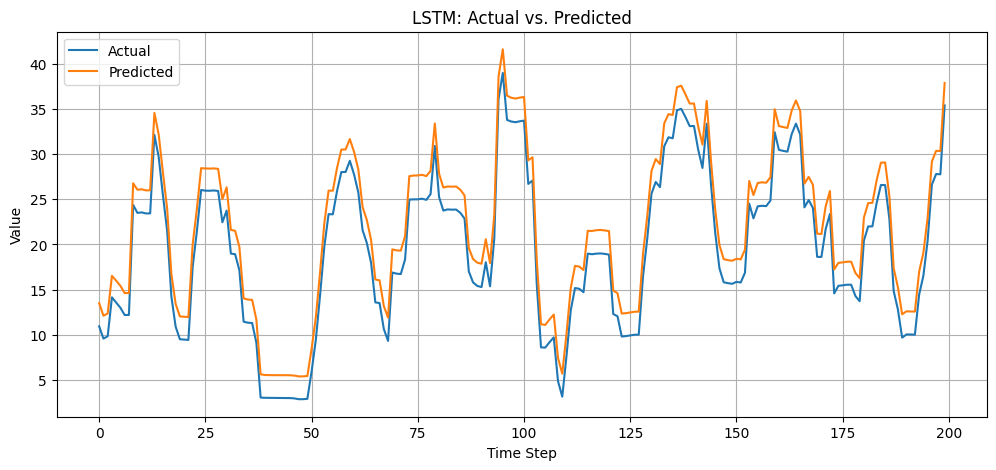

In [66]:

# Calculate and Store Metrics
lstm_r2 = r2_score(lstm_true_rescaled, lstm_preds_rescaled)
lstm_rmse = np.sqrt(mean_squared_error(lstm_true_rescaled, lstm_preds_rescaled))
lstm_mae = mean_absolute_error(lstm_true_rescaled, lstm_preds_rescaled)
r2_scores['LSTM'] = lstm_r2
rmse_scores['LSTM'] = lstm_rmse
mae_scores['LSTM'] = lstm_mae

print(f"\nLSTM Final R² Score: {lstm_r2:.4f}")
print(f"LSTM Final RMSE:       {lstm_rmse:.4f}")
print(f"LSTM Final MAE:        {lstm_mae:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(lstm_true_rescaled[:200], label='Actual')
plt.plot(lstm_preds_rescaled[:200], label='Predicted')
plt.title('LSTM: Actual vs. Predicted')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [67]:

# ==============================================================================
# Part 4: Procedural Bidirectional LSTM (BiLSTM)
# ==============================================================================
print("\n\n" + "="*60); print("PART 4: PROCEDURAL BIDIRECTIONAL LSTM (BILSTM)"); print("="*60)
# --- BiLSTM Hyperparameters & Setup ---
print("\n--- Setting up BiLSTM Model Parameters ---")
# Model Architecture Parameters
BILSTM_INPUT_DIM = X_train.shape[2]
BILSTM_HIDDEN_DIM = 64
BILSTM_NUM_LAYERS = 1
BILSTM_OUTPUT_DIM = 1
BILSTM_DROPOUT = 0.0







PART 4: PROCEDURAL BIDIRECTIONAL LSTM (BILSTM)

--- Setting up BiLSTM Model Parameters ---


In [68]:

# Training Hyperparameters
BILSTM_EPOCHS = 20
BILSTM_BATCH_SIZE = 32
BILSTM_LEARNING_RATE = 0.001
bilstm_layer = nn.LSTM(BILSTM_INPUT_DIM, BILSTM_HIDDEN_DIM, BILSTM_NUM_LAYERS, batch_first=True, bidirectional=True, dropout=BILSTM_DROPOUT).to(device)
bilstm_fc_layer = nn.Linear(BILSTM_HIDDEN_DIM * 2, BILSTM_OUTPUT_DIM).to(device)
bilstm_optimizer = torch.optim.Adam(itertools.chain(bilstm_layer.parameters(), bilstm_fc_layer.parameters()), lr=BILSTM_LEARNING_RATE)
bilstm_criterion = nn.MSELoss()
bilstm_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BILSTM_BATCH_SIZE, shuffle=True)
loss_history['BiLSTM'] = []
val_loss_history['BiLSTM'] = []


In [69]:

# --- BiLSTM Model Training ---
print("\n--- Starting BiLSTM Model Training ---")
for epoch in range(BILSTM_EPOCHS):
    bilstm_layer.train()
    bilstm_fc_layer.train()
    running_loss = 0.0
    for xb, yb in bilstm_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        rnn_out, _ = bilstm_layer(xb)
        pred = bilstm_fc_layer(rnn_out[:, -1, :])
        loss = bilstm_criterion(pred, yb)
        bilstm_optimizer.zero_grad()
        loss.backward()
        bilstm_optimizer.step()
        running_loss += loss.item()
        
    avg_epoch_loss = running_loss / len(bilstm_train_loader)
    loss_history['BiLSTM'].append(avg_epoch_loss)
    bilstm_layer.eval()
    bilstm_fc_layer.eval()
    with torch.no_grad():
        rnn_out, _ = bilstm_layer(X_val.to(device))
        val_pred = bilstm_fc_layer(rnn_out[:, -1, :])
        val_loss = bilstm_criterion(val_pred, Y_val.to(device))
        val_loss_history['BiLSTM'].append(val_loss.item())
        
    print(f"BiLSTM Epoch {epoch+1:2d}/{BILSTM_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")
print("--- BiLSTM Training Complete ---")




--- Starting BiLSTM Model Training ---
BiLSTM Epoch  1/20 | Train Loss: 0.000928 | Val Loss: 0.000119
BiLSTM Epoch  2/20 | Train Loss: 0.000003 | Val Loss: 0.000117
BiLSTM Epoch  3/20 | Train Loss: 0.000001 | Val Loss: 0.000116
BiLSTM Epoch  4/20 | Train Loss: 0.000001 | Val Loss: 0.000097
BiLSTM Epoch  5/20 | Train Loss: 0.000001 | Val Loss: 0.000085
BiLSTM Epoch  6/20 | Train Loss: 0.000001 | Val Loss: 0.000070
BiLSTM Epoch  7/20 | Train Loss: 0.000001 | Val Loss: 0.000064
BiLSTM Epoch  8/20 | Train Loss: 0.000001 | Val Loss: 0.000061
BiLSTM Epoch  9/20 | Train Loss: 0.000001 | Val Loss: 0.000062
BiLSTM Epoch 10/20 | Train Loss: 0.000001 | Val Loss: 0.000063
BiLSTM Epoch 11/20 | Train Loss: 0.000001 | Val Loss: 0.000055
BiLSTM Epoch 12/20 | Train Loss: 0.000001 | Val Loss: 0.000060
BiLSTM Epoch 13/20 | Train Loss: 0.000001 | Val Loss: 0.000069
BiLSTM Epoch 14/20 | Train Loss: 0.000001 | Val Loss: 0.000065
BiLSTM Epoch 15/20 | Train Loss: 0.000001 | Val Loss: 0.000063
BiLSTM Epoch 16

In [70]:
# --- BiLSTM Model Evaluation ---
bilstm_layer.eval()
bilstm_fc_layer.eval()
with torch.no_grad():
    rnn_out, _ = bilstm_layer(X_test.to(device))
    bilstm_preds = bilstm_fc_layer(rnn_out[:, -1, :])
    bilstm_preds_rescaled = target_scaler.inverse_transform(bilstm_preds.cpu().numpy())
bilstm_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())



BiLSTM Final R² Score: 0.9867
BiLSTM Final RMSE:       1.1698
BiLSTM Final MAE:        1.1605


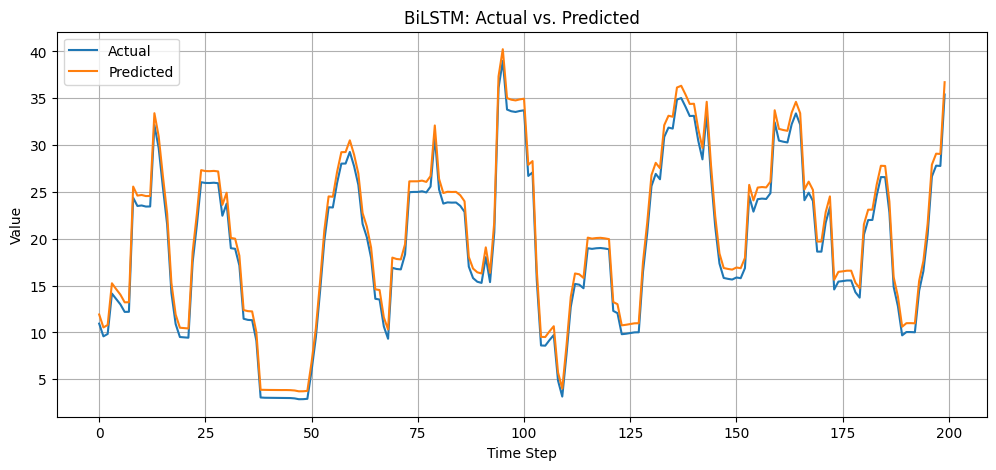

In [71]:

# Calculate and Store Metrics
bilstm_r2 = r2_score(bilstm_true_rescaled, bilstm_preds_rescaled)
bilstm_rmse = np.sqrt(mean_squared_error(bilstm_true_rescaled, bilstm_preds_rescaled))
bilstm_mae = mean_absolute_error(bilstm_true_rescaled, bilstm_preds_rescaled)
r2_scores['BiLSTM'] = bilstm_r2
rmse_scores['BiLSTM'] = bilstm_rmse
mae_scores['BiLSTM'] = bilstm_mae

print(f"\nBiLSTM Final R² Score: {bilstm_r2:.4f}")
print(f"BiLSTM Final RMSE:       {bilstm_rmse:.4f}")
print(f"BiLSTM Final MAE:        {bilstm_mae:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(bilstm_true_rescaled[:200], label='Actual')
plt.plot(bilstm_preds_rescaled[:200], label='Predicted')
plt.title('BiLSTM: Actual vs. Predicted')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [72]:

# ==============================================================================
# Part 5: Procedural Unidirectional GRU
# ==============================================================================
print("\n\n" + "="*60); print("PART 5: PROCEDURAL UNIDIRECTIONAL GRU"); print("="*60)
# --- GRU Hyperparameters & Setup ---
print("\n--- Setting up GRU Model Parameters ---")
# Model Architecture Parameters
GRU_INPUT_DIM = X_train.shape[2]
GRU_HIDDEN_DIM = 64
GRU_NUM_LAYERS = 1
GRU_OUTPUT_DIM = 1
GRU_DROPOUT = 0.0





PART 5: PROCEDURAL UNIDIRECTIONAL GRU

--- Setting up GRU Model Parameters ---


In [73]:

# Training Hyperparameters
GRU_EPOCHS = 20
GRU_BATCH_SIZE = 32
GRU_LEARNING_RATE = 0.001
gru_layer = nn.GRU(GRU_INPUT_DIM, GRU_HIDDEN_DIM, GRU_NUM_LAYERS, batch_first=True, dropout=GRU_DROPOUT).to(device)
gru_fc_layer = nn.Linear(GRU_HIDDEN_DIM, GRU_OUTPUT_DIM).to(device)
gru_optimizer = torch.optim.Adam(itertools.chain(gru_layer.parameters(), gru_fc_layer.parameters()), lr=GRU_LEARNING_RATE)
gru_criterion = nn.MSELoss()
gru_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=GRU_BATCH_SIZE, shuffle=True)
loss_history['GRU'] = []
val_loss_history['GRU'] = []


In [74]:

# --- GRU Model Training ---
print("\n--- Starting GRU Model Training ---")
for epoch in range(GRU_EPOCHS):
    gru_layer.train()
    gru_fc_layer.train()
    running_loss = 0.0
    for xb, yb in gru_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        rnn_out, _ = gru_layer(xb)
        pred = gru_fc_layer(rnn_out[:, -1, :])
        loss = gru_criterion(pred, yb)
        gru_optimizer.zero_grad()
        loss.backward()
        gru_optimizer.step()
        running_loss += loss.item()
        
    avg_epoch_loss = running_loss / len(gru_train_loader)
    loss_history['GRU'].append(avg_epoch_loss)
    gru_layer.eval()
    gru_fc_layer.eval()
    with torch.no_grad():
        rnn_out, _ = gru_layer(X_val.to(device))
        val_pred = gru_fc_layer(rnn_out[:, -1, :])
        val_loss = gru_criterion(val_pred, Y_val.to(device))
        val_loss_history['GRU'].append(val_loss.item())
        
    print(f"GRU Epoch {epoch+1:2d}/{GRU_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")
print("--- GRU Training Complete ---")



--- Starting GRU Model Training ---
GRU Epoch  1/20 | Train Loss: 0.000759 | Val Loss: 0.001199
GRU Epoch  2/20 | Train Loss: 0.000002 | Val Loss: 0.001173
GRU Epoch  3/20 | Train Loss: 0.000001 | Val Loss: 0.001102
GRU Epoch  4/20 | Train Loss: 0.000001 | Val Loss: 0.001068
GRU Epoch  5/20 | Train Loss: 0.000002 | Val Loss: 0.000967
GRU Epoch  6/20 | Train Loss: 0.000002 | Val Loss: 0.000737
GRU Epoch  7/20 | Train Loss: 0.000002 | Val Loss: 0.000634
GRU Epoch  8/20 | Train Loss: 0.000002 | Val Loss: 0.000544
GRU Epoch  9/20 | Train Loss: 0.000002 | Val Loss: 0.000385
GRU Epoch 10/20 | Train Loss: 0.000001 | Val Loss: 0.000358
GRU Epoch 11/20 | Train Loss: 0.000001 | Val Loss: 0.000287
GRU Epoch 12/20 | Train Loss: 0.000002 | Val Loss: 0.000236
GRU Epoch 13/20 | Train Loss: 0.000001 | Val Loss: 0.000267
GRU Epoch 14/20 | Train Loss: 0.000001 | Val Loss: 0.000182
GRU Epoch 15/20 | Train Loss: 0.000001 | Val Loss: 0.000155
GRU Epoch 16/20 | Train Loss: 0.000001 | Val Loss: 0.000135
GRU

In [75]:

# --- GRU Model Evaluation ---
gru_layer.eval()
gru_fc_layer.eval()
with torch.no_grad():
    rnn_out, _ = gru_layer(X_test.to(device))
    gru_preds = gru_fc_layer(rnn_out[:, -1, :])
    gru_preds_rescaled = target_scaler.inverse_transform(gru_preds.cpu().numpy())
gru_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())



GRU Final R² Score: 0.9846
GRU Final RMSE:       1.2611
GRU Final MAE:        1.2555


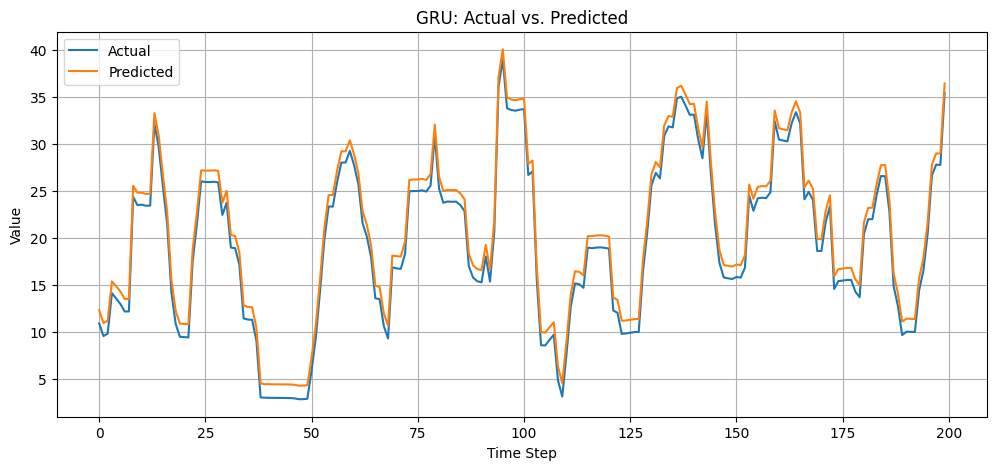

In [76]:

# Calculate and Store Metrics
gru_r2 = r2_score(gru_true_rescaled, gru_preds_rescaled)
gru_rmse = np.sqrt(mean_squared_error(gru_true_rescaled, gru_preds_rescaled))
gru_mae = mean_absolute_error(gru_true_rescaled, gru_preds_rescaled)
r2_scores['GRU'] = gru_r2
rmse_scores['GRU'] = gru_rmse
mae_scores['GRU'] = gru_mae

print(f"\nGRU Final R² Score: {gru_r2:.4f}")
print(f"GRU Final RMSE:       {gru_rmse:.4f}")
print(f"GRU Final MAE:        {gru_mae:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(gru_true_rescaled[:200], label='Actual')
plt.plot(gru_preds_rescaled[:200], label='Predicted')
plt.title('GRU: Actual vs. Predicted')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [77]:

# ==============================================================================
# Part 6: Procedural Bidirectional GRU (BiGRU)
# ==============================================================================
print("\n\n" + "="*60); print("PART 6: PROCEDURAL BIDIRECTIONAL GRU (BIGRU)"); print("="*60)
# --- BiGRU Hyperparameters & Setup ---
print("\n--- Setting up BiGRU Model Parameters ---")
# Model Architecture Parameters
BIGRU_INPUT_DIM = X_train.shape[2]
BIGRU_HIDDEN_DIM = 64
BIGRU_NUM_LAYERS = 1
BIGRU_OUTPUT_DIM = 1
BIGRU_DROPOUT = 0.0





PART 6: PROCEDURAL BIDIRECTIONAL GRU (BIGRU)

--- Setting up BiGRU Model Parameters ---


In [78]:

# Training Hyperparameters
BIGRU_EPOCHS = 20
BIGRU_BATCH_SIZE = 32
BIGRU_LEARNING_RATE = 0.001
bigru_layer = nn.GRU(BIGRU_INPUT_DIM, BIGRU_HIDDEN_DIM, BIGRU_NUM_LAYERS, batch_first=True, bidirectional=True, dropout=BIGRU_DROPOUT).to(device)
bigru_fc_layer = nn.Linear(BIGRU_HIDDEN_DIM * 2, BIGRU_OUTPUT_DIM).to(device)
bigru_optimizer = torch.optim.Adam(itertools.chain(bigru_layer.parameters(), bigru_fc_layer.parameters()), lr=BIGRU_LEARNING_RATE)
bigru_criterion = nn.MSELoss()
bigru_train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BIGRU_BATCH_SIZE, shuffle=True)
loss_history['BiGRU'] = []
val_loss_history['BiGRU'] = []


In [79]:

# --- BiGRU Model Training ---
print("\n--- Starting BiGRU Model Training ---")
for epoch in range(BIGRU_EPOCHS):
    bigru_layer.train()
    bigru_fc_layer.train()
    running_loss = 0.0
    for xb, yb in bigru_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        rnn_out, _ = bigru_layer(xb)
        pred = bigru_fc_layer(rnn_out[:, -1, :])
        loss = bigru_criterion(pred, yb)
        bigru_optimizer.zero_grad()
        loss.backward()
        bigru_optimizer.step()
        running_loss += loss.item()
        
    avg_epoch_loss = running_loss / len(bigru_train_loader)
    loss_history['BiGRU'].append(avg_epoch_loss)
    bigru_layer.eval()
    bigru_fc_layer.eval()
    with torch.no_grad():
        rnn_out, _ = bigru_layer(X_val.to(device))
        val_pred = bigru_fc_layer(rnn_out[:, -1, :])
        val_loss = gru_criterion(val_pred, Y_val.to(device))
        val_loss_history['BiGRU'].append(val_loss.item())
        
    print(f"BiGRU Epoch {epoch+1:2d}/{BIGRU_EPOCHS} | Train Loss: {avg_epoch_loss:.6f} | Val Loss: {val_loss.item():.6f}")
print("--- BiGRU Training Complete ---")



--- Starting BiGRU Model Training ---
BiGRU Epoch  1/20 | Train Loss: 0.000892 | Val Loss: 0.000949
BiGRU Epoch  2/20 | Train Loss: 0.000002 | Val Loss: 0.000934
BiGRU Epoch  3/20 | Train Loss: 0.000001 | Val Loss: 0.001011
BiGRU Epoch  4/20 | Train Loss: 0.000001 | Val Loss: 0.001011
BiGRU Epoch  5/20 | Train Loss: 0.000001 | Val Loss: 0.001162
BiGRU Epoch  6/20 | Train Loss: 0.000001 | Val Loss: 0.001102
BiGRU Epoch  7/20 | Train Loss: 0.000002 | Val Loss: 0.001013
BiGRU Epoch  8/20 | Train Loss: 0.000001 | Val Loss: 0.001000
BiGRU Epoch  9/20 | Train Loss: 0.000002 | Val Loss: 0.000947
BiGRU Epoch 10/20 | Train Loss: 0.000001 | Val Loss: 0.000902
BiGRU Epoch 11/20 | Train Loss: 0.000002 | Val Loss: 0.000817
BiGRU Epoch 12/20 | Train Loss: 0.000002 | Val Loss: 0.000857
BiGRU Epoch 13/20 | Train Loss: 0.000001 | Val Loss: 0.000926
BiGRU Epoch 14/20 | Train Loss: 0.000001 | Val Loss: 0.000790
BiGRU Epoch 15/20 | Train Loss: 0.000001 | Val Loss: 0.000904
BiGRU Epoch 16/20 | Train Loss:

In [80]:

# --- BiGRU Model Evaluation ---
bigru_layer.eval()
bigru_fc_layer.eval()
with torch.no_grad():
    rnn_out, _ = bigru_layer(X_test.to(device))
    bigru_preds = bigru_fc_layer(rnn_out[:, -1, :])
    bigru_preds_rescaled = target_scaler.inverse_transform(bigru_preds.cpu().numpy())
bigru_true_rescaled = target_scaler.inverse_transform(Y_test.cpu().numpy())



BiGRU Final R² Score: 0.8381
BiGRU Final RMSE:       4.0828
BiGRU Final MAE:        4.0824


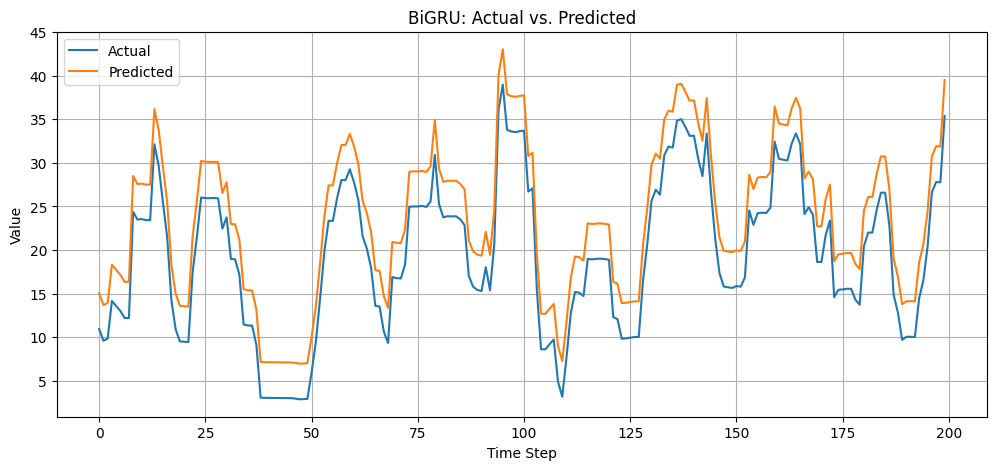

In [81]:

# Calculate and Store Metrics
bigru_r2 = r2_score(bigru_true_rescaled, bigru_preds_rescaled)
bigru_rmse = np.sqrt(mean_squared_error(bigru_true_rescaled, bigru_preds_rescaled))
bigru_mae = mean_absolute_error(bigru_true_rescaled, bigru_preds_rescaled)
r2_scores['BiGRU'] = bigru_r2
rmse_scores['BiGRU'] = bigru_rmse
mae_scores['BiGRU'] = bigru_mae

print(f"\nBiGRU Final R² Score: {bigru_r2:.4f}")
print(f"BiGRU Final RMSE:       {bigru_rmse:.4f}")
print(f"BiGRU Final MAE:        {bigru_mae:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(bigru_true_rescaled[:200], label='Actual')
plt.plot(bigru_preds_rescaled[:200], label='Predicted')
plt.title('BiGRU: Actual vs. Predicted')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [82]:

# ==============================================================================
# Part 7: Final Metrics Comparison
# ==============================================================================
print("\n\n" + "="*50); print("📊 Final Metrics Comparison 📊"); print("="*50)
print(f"{'Model':<10} | {'R² Score':>10} | {'RMSE':>10} | {'MAE':>10}")
print("-" * 50)
model_order = ['TCN', 'LSTM', 'BiLSTM', 'GRU', 'BiGRU']
for model_name in model_order:
    r2 = r2_scores.get(model_name, float('nan'))
    rmse = rmse_scores.get(model_name, float('nan'))
    mae = mae_scores.get(model_name, float('nan'))
    print(f"{model_name:<10} | {r2:>10.4f} | {rmse:>10.4f} | {mae:>10.4f}")
print("="*50)




📊 Final Metrics Comparison 📊
Model      |   R² Score |       RMSE |        MAE
--------------------------------------------------
TCN        |     0.9097 |     3.0497 |     3.0226
LSTM       |     0.9411 |     2.4634 |     2.4593
BiLSTM     |     0.9867 |     1.1698 |     1.1605
GRU        |     0.9846 |     1.2611 |     1.2555
BiGRU      |     0.8381 |     4.0828 |     4.0824




PART 8: COMPARATIVE TRAINING LOSS CURVES
Displaying the comparative training loss graph. Close the plot to continue.


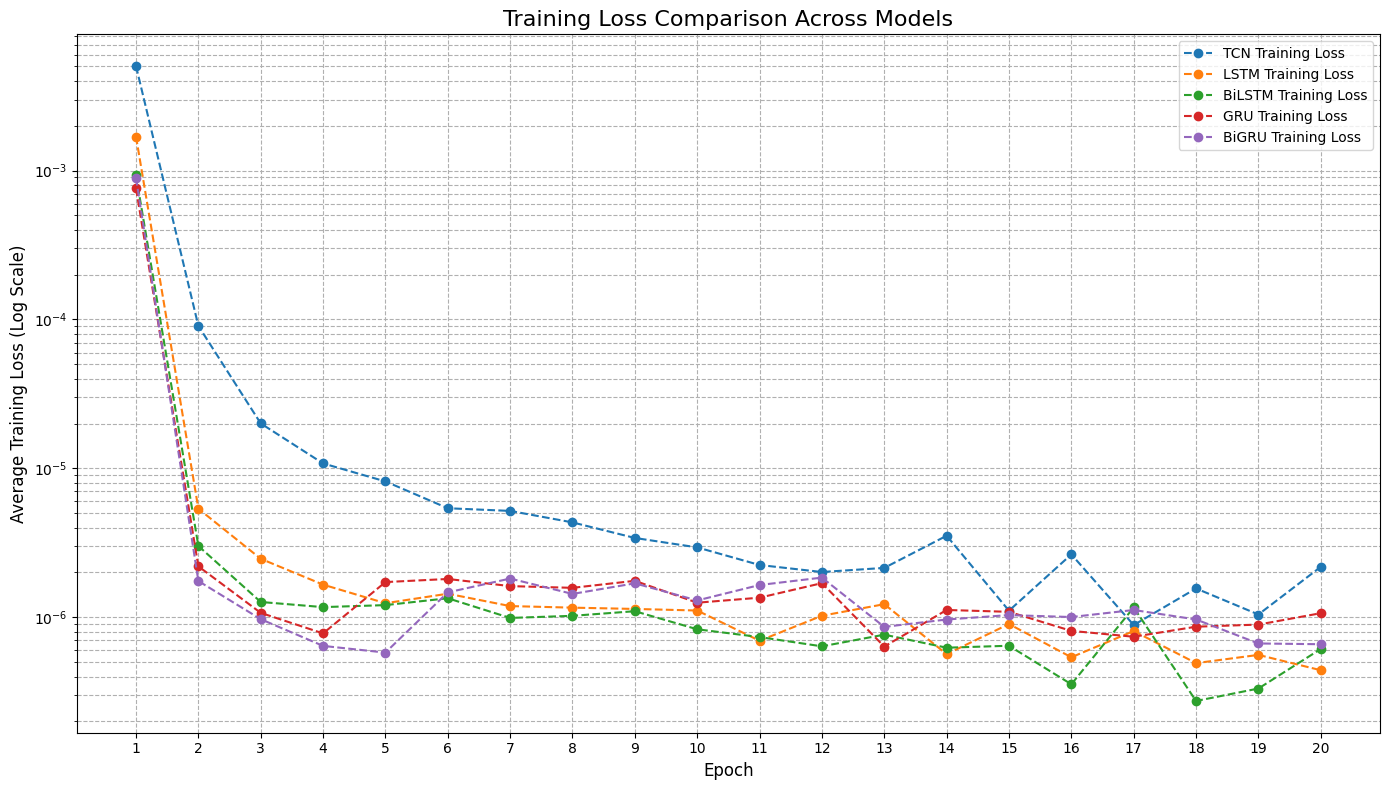

In [83]:

# ==============================================================================
# Part 8: Comparative Training Loss Graph
# ==============================================================================
print("\n\n" + "="*60); print("PART 8: COMPARATIVE TRAINING LOSS CURVES"); print("="*60)
plt.figure(figsize=(14, 8))
for model_name, losses in loss_history.items():
    plt.plot(range(1, len(losses) + 1), losses, label=f'{model_name} Training Loss', marker='o', linestyle='--')
plt.title('Training Loss Comparison Across Models', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Training Loss (Log Scale)', fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.xticks(range(1, TCN_EPOCHS + 1))
plt.yscale('log')
plt.tight_layout()
print("Displaying the comparative training loss graph. Close the plot to continue.")
plt.show()



In [84]:

# ==============================================================================
# Part 9: Per-Model Training vs. Validation Loss Graphs (Simplified)
# ==============================================================================
print("\n\n" + "="*60); print("PART 9: PER-MODEL TRAINING VS. VALIDATION LOSS"); print("="*60)




PART 9: PER-MODEL TRAINING VS. VALIDATION LOSS


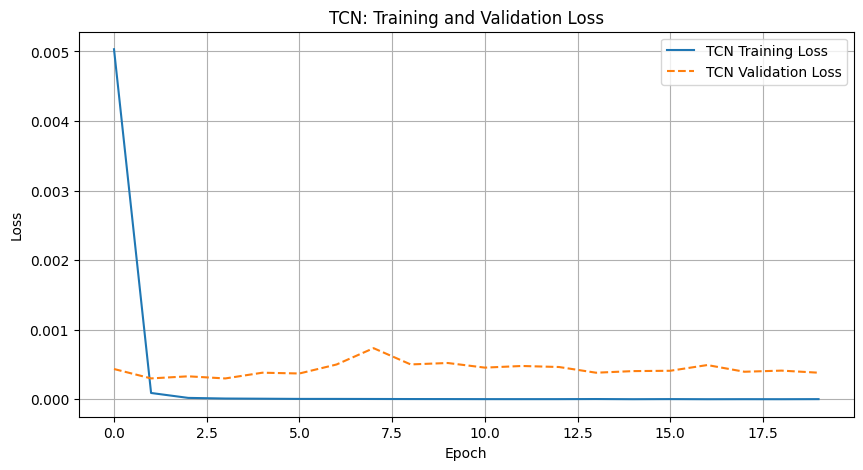

In [85]:

# --- TCN Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['TCN'], label="TCN Training Loss")
plt.plot(val_loss_history['TCN'], label="TCN Validation Loss", linestyle='--')
plt.title("TCN: Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


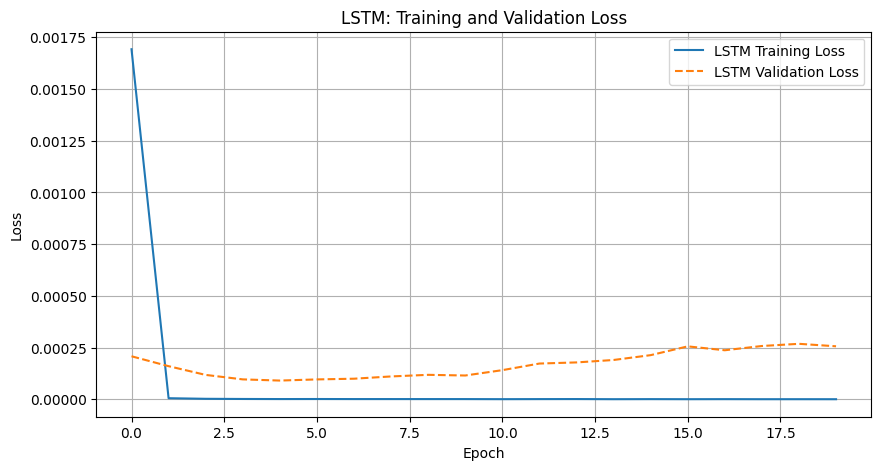

In [86]:

# --- LSTM Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['LSTM'], label="LSTM Training Loss")
plt.plot(val_loss_history['LSTM'], label="LSTM Validation Loss", linestyle='--')
plt.title("LSTM: Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


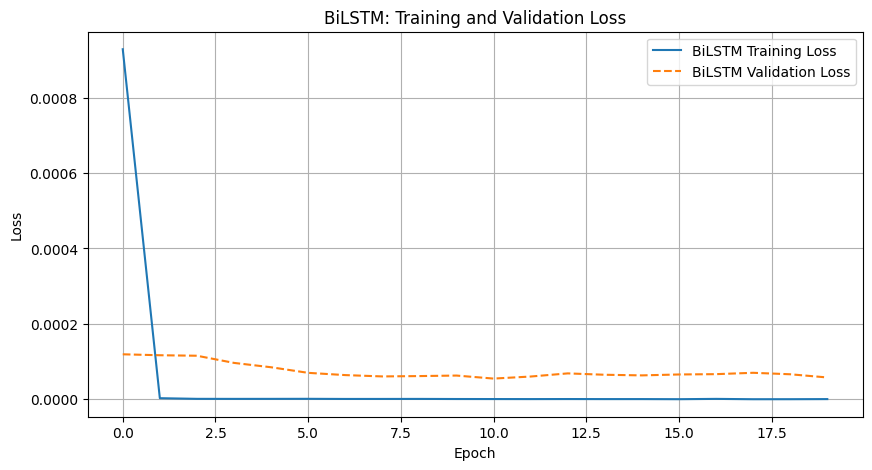

In [87]:

# --- BiLSTM Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['BiLSTM'], label="BiLSTM Training Loss")
plt.plot(val_loss_history['BiLSTM'], label="BiLSTM Validation Loss", linestyle='--')
plt.title("BiLSTM: Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


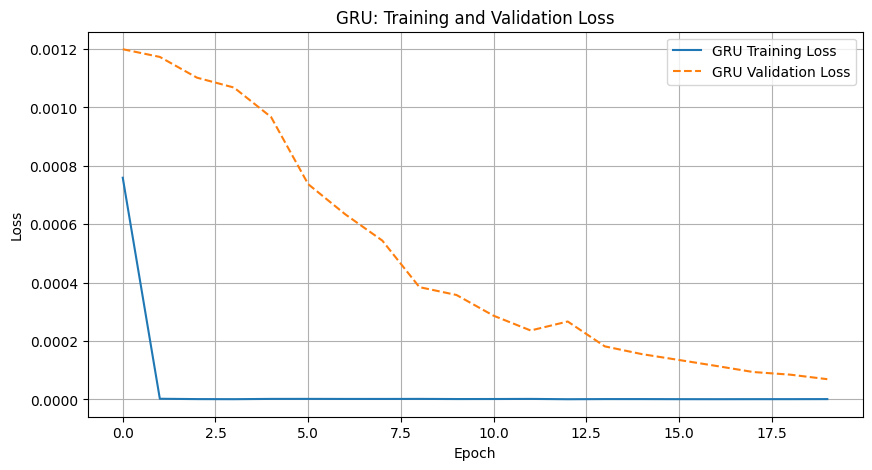

In [88]:

# --- GRU Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['GRU'], label="GRU Training Loss")
plt.plot(val_loss_history['GRU'], label="GRU Validation Loss", linestyle='--')
plt.title("GRU: Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


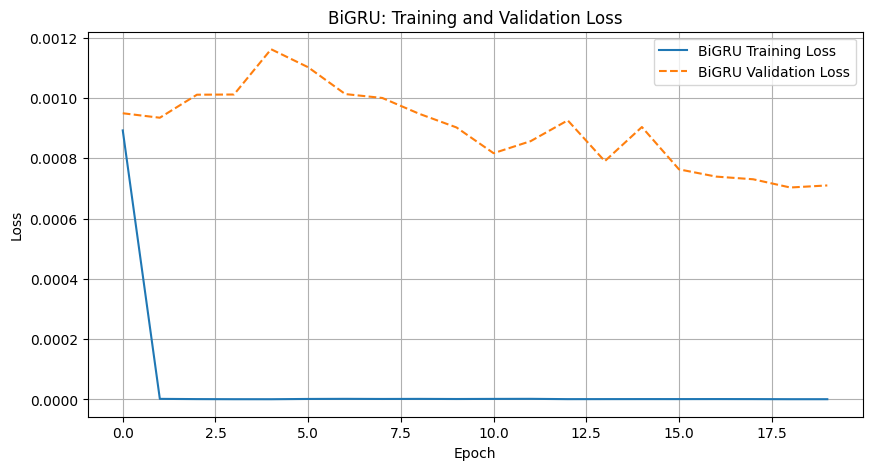

In [89]:

# --- BiGRU Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history['BiGRU'], label="BiGRU Training Loss")
plt.plot(val_loss_history['BiGRU'], label="BiGRU Validation Loss", linestyle='--')
plt.title("BiGRU: Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [90]:

print("\nAll analysis and plotting complete.")


All analysis and plotting complete.
